In [1]:
%load_ext lab_black
%matplotlib inline

# Build GeoJSON files from airspace environment data

In [2]:
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd

#### Airspace Environment data can be found in EUROCONTROL DDR2 web portal (Dataset Files/Airspace Environment Datasets)

In [3]:
env_folder = "your_ENV_folder"

#### <br> Load airblocks coordinates

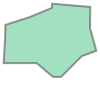

In [4]:
with open(glob(env_folder + "/Sectors*.are")[0]) as are:
    lines = are.readlines()

airblocks = defaultdict(list)
name = ""
for l in lines:
    elems = l.strip().split(" ")
    if len(elems) > 2:
        name = elems[-1]
    else:
        airblocks[name].append((float(elems[1]) / 60, float(elems[0]) / 60))  # lon, lat

Polygon(airblocks["039LF"])

#### <br> Load elementary airspace volumes with associated airblocks

In [5]:
sls = pd.read_csv(
    glob(env_folder + "/Sectors*.sls")[0],
    sep=" ",
    header=None,
    names=["airspace", "_", "airblock", "flmin", "flmax"],
)
sls.drop(["_"], axis=1, inplace=True)
sls.head()

,airspace,airblock,flmin,flmax
0,BGGLFIR,002BG,0,999
1,BIDCT,001BI,0,999
2,BIDCT,002BI,0,999
3,BIDCT,003BI,0,999
4,BIDCT,004BI,0,999


#### Add airblocks geodata

In [6]:
sls["geometry"] = sls["airblock"].apply(lambda x: Polygon(airblocks[x]))
geo_sls = gpd.GeoDataFrame(sls)
geo_sls.head()

,airspace,airblock,flmin,flmax,geometry
0,BGGLFIR,002BG,0,999,"POLYGON ((-60.00000 89.00000, 30.00000 89.0000..."
1,BIDCT,001BI,0,999,"POLYGON ((-22.96667 64.63333, -22.88333 64.783..."
2,BIDCT,002BI,0,999,"POLYGON ((-15.17667 66.75000, -22.88333 64.783..."
3,BIDCT,003BI,0,999,"POLYGON ((0.00000 63.47611, 0.00000 63.25000, ..."
4,BIDCT,004BI,0,999,"POLYGON ((-15.17667 66.75000, -14.00000 66.000..."


#### <br> Load all collapse airspace volumes

In [7]:
spc = pd.read_csv(glob(env_folder + "/Sectors*.spc")[0], sep=";")
collapse = defaultdict(list)
name = ""
for _, row in spc.iterrows():
    if row[0] == "A":
        name = row[1]
    elif row[0] == "S":
        collapse[name].append(row[1])

print(collapse["LFBBRL12"])

['LFBBL1', 'LFBBL2', 'LFBBR1', 'LFBBR2']


#### <br> Get 3D geometry of a collapse airspace volume

In [8]:
def geom(ap):
    return geo_sls.query(f"airspace in {collapse[ap]}")

In [9]:
df = geom("LFBBUBDX")
df.head()

,airspace,airblock,flmin,flmax,geometry
14900,LFBBH1,104LF,195,295,"POLYGON ((3.36917 44.85889, 4.27361 44.43167, ..."
14901,LFBBH2,104LF,295,345,"POLYGON ((3.36917 44.85889, 4.27361 44.43167, ..."
14902,LFBBH3,104LF,345,365,"POLYGON ((3.36917 44.85889, 4.27361 44.43167, ..."
14903,LFBBH4,104LF,365,385,"POLYGON ((3.36917 44.85889, 4.27361 44.43167, ..."
14904,LFBBH5,104LF,385,999,"POLYGON ((3.36917 44.85889, 4.27361 44.43167, ..."


#### Ex: 2D visualization of LFBBUBDX at FL195 and FL345

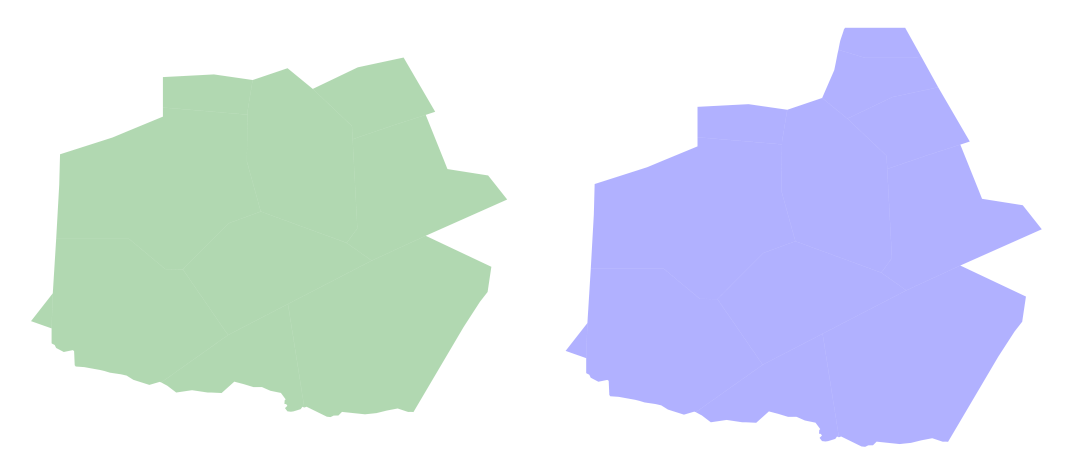

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
df.query("flmin == 195").plot(ax=axes[0], alpha=0.3, color="green")
df.query("flmin == 345").plot(ax=axes[1], alpha=0.3, color="blue")
for i in range(2):
    axes[i].set_axis_off()
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
fig.tight_layout()
plt.savefig("ubdx.png")
plt.show()

#### <br> Export to GeoJSON

In [11]:
def gson(ap, file_name):
    geo_sls.query(f"airspace in {collapse[ap]}").to_file(file_name, driver="GeoJSON")

In [12]:
gson("LFBBUBDX", "ubdx.geojson")

In [13]:
gdf = gpd.read_file("ubdx.geojson")
gdf.head()

,airspace,airblock,flmin,flmax,geometry
0,LFBBH1,104LF,195,295,"POLYGON ((3.36917 44.85889, 4.27361 44.43167, ..."
1,LFBBH2,104LF,295,345,"POLYGON ((3.36917 44.85889, 4.27361 44.43167, ..."
2,LFBBH3,104LF,345,365,"POLYGON ((3.36917 44.85889, 4.27361 44.43167, ..."
3,LFBBH4,104LF,365,385,"POLYGON ((3.36917 44.85889, 4.27361 44.43167, ..."
4,LFBBH5,104LF,385,999,"POLYGON ((3.36917 44.85889, 4.27361 44.43167, ..."
